In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform, LinearFilterBank, DyadicFilterBank
import matplotlib.pyplot as plt
from invertiblewavelets import Cauchy
from scipy import signal

"This notebook requires MAGPRIME for data loading. Uncomment to install."
# !pip install git+https://github.com/aphoffmann/MAGPRIME.git
from magprime import utility
%matplotlib inline

c:\Users\aphoffm2\AppData\Local\anaconda3\envs\mag\Lib\site-packages\pymssa\mssa.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [2]:
data = utility.load_swarm_data(160000,165000)[2] 
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array

c:\Users\aphoffm2\AppData\Local\anaconda3\envs\mag\Lib\site-packages\magprime\utility\data_loader.py:28: DtypeWarning: Columns (2,5,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path, sep=',',header=None)


#### Create Transform Object and Analysis Filters

In [3]:
"Filterbank"
fb = DyadicFilterBank(wavelet=Cauchy(1000) , fs=sample_rate, N=5000, real=True, s_max = 2, dj = 1/12, compensation=True)

"Transform"
transform = Transform.from_filterbank(fb)

Text(0.5, 1.0, 'Filterbank Frequencies')

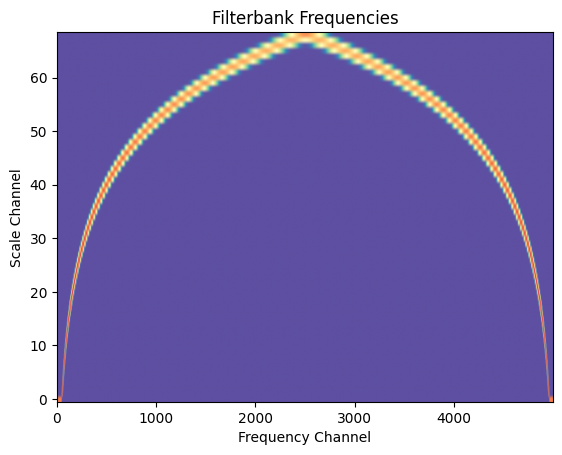

In [4]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r', interpolation=None)
ax.set_ylabel('Scale Channel')
ax.set_xlabel('Frequency Channel')
plt.title('Filterbank Frequencies')

#### Plot Wavelet Coefficients

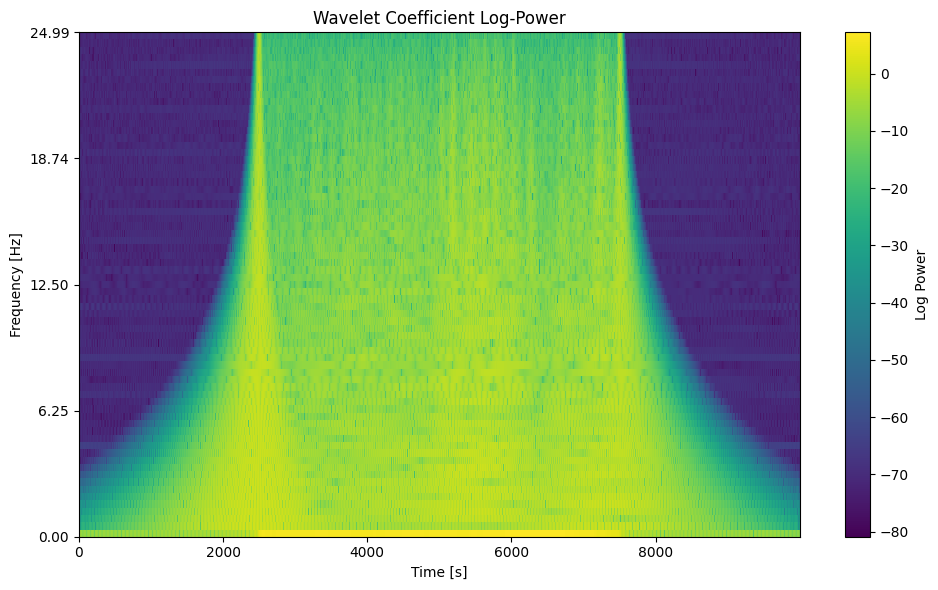

In [5]:
# Perform forward wavelet transform
coefficients = transform.forward(data, mode='full')
transform.scalogram(coefficients, fb.channel_freqs)

(69, 9999)
Reconstruction error: 5.748988936466005e-14


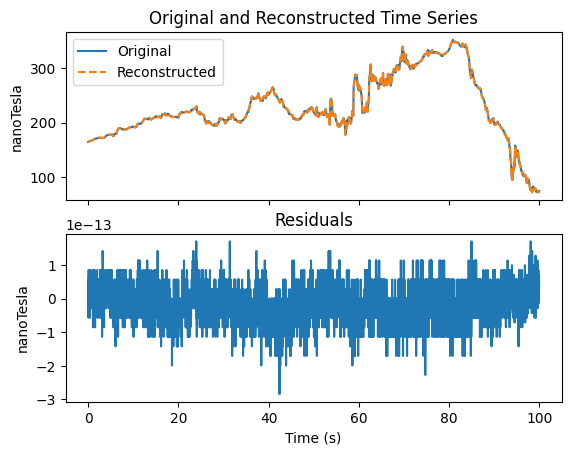

In [6]:
# Perform forward wavelet transform
coefficients = transform.forward(data, mode='full')
print(coefficients.shape)
# Perform inverse wavelet transform (reconstruction)
reconstructed = transform.inverse(coefficients, mode='full', Lx = 5000)

# Calculate and print reconstruction error
reconstruction_error = np.sqrt(np.mean((reconstructed - data)**2))
print(f"Reconstruction error: {reconstruction_error}")

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(t, data, label='Original')
ax[0].plot(t, reconstructed, label='Reconstructed', linestyle='--')    
ax[0].set_ylabel('nanoTesla')
ax[0].legend()
ax[0].set_title('Original and Reconstructed Time Series')
ax[1].plot(t, data - reconstructed)
ax[1].set_title('Residuals')
ax[1].set_ylabel('nanoTesla')
ax[1].set_xlabel('Time (s)')
plt.show()

#### Check Wavelet Orthgonality

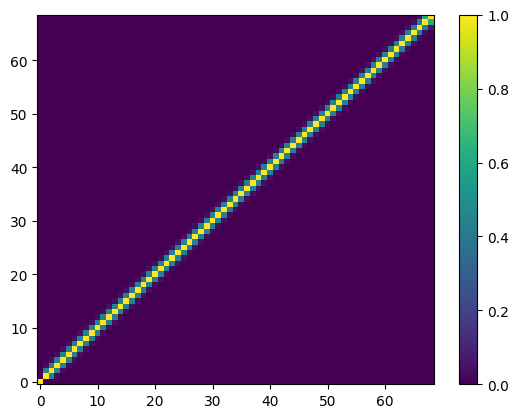

In [7]:
w_time = np.fft.ifft(transform.Wfreq, axis=-1)
delta_kl = w_time.conj() @ w_time.T
delta_kl = delta_kl / np.max(delta_kl, axis=1)[:, np.newaxis]
plt.imshow(np.abs(delta_kl), aspect='auto', origin='lower')
cbar = plt.colorbar()